# Rian Dolphin - Challenge 1 <img align="right" src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">

This notebook contains the code I used to develop a solution for fire mapping using the infrared line-scan images provided.

### Import libraries and instantiate a datacube

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime

from datacube import Datacube
import matplotlib.pyplot as plt

sys.path.append("../scripts")
from dea_plotting import map_shapefile
from dea_spatialtools import xr_rasterize

import cv2

from tqdm import tqdm
from sklearn.metrics import f1_score

import xarray as xr


import sys, os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

import tensorflow as tf
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot

dc = Datacube(app="Getting started")

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Import variables
### Import input variable: aerial linescan images

In [2]:
#-- Query the datacube object to identify what linescans are available. 
#- Also sort them by ID to ensure they're ordered consistently.
linescan_datasets = dc.find_datasets(product='linescan')
linescan_datasets = sorted(linescan_datasets, key = lambda ds: (ds.center_time, ds.id))

ds = dc.load(product='linescan', id=linescan_datasets[23].id, output_crs='epsg:28355', resolution=(-10,10))

#-- The 'challenge1_train.csv' file lists the names of all the training linescans that are available.
train = pd.read_csv('resources/challenge1_train.csv', index_col='id')

### Import Target Variable: Fire Map Polygons

In [3]:
#-- load the dataset.
vector_file = 'resources/fire_boundaries.shp'
gdf = gpd.read_file(vector_file)
#print('Number of objects in geodataframe: ' + str(len(gdf)))

## Import Polygons and Deal With Composites Etc.

In [4]:
composites = gdf[gdf.SourceName.str.upper().str.contains(",|&|(COMPOSITE)", na=False)]

/env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [5]:
def clean_name(name):
    if name is None:
        res = None
    else:
        if name.upper()[-4::] == ".JPG":
            res = name.upper()[:-4].replace(' ','_')
        else:
            res = name.upper().replace(' ','_')
    return res

# test_string = 'aberfeldy west 200 p1_201901260955_mga94_55.jpg'
# test_string_composite = 'Composite wallhalla 397,398 & 401 20190225 (1311 to 1342hrs)'
# print(clean_name(test_string))
# print(clean_name(test_string_composite))

In [6]:
gdf['SourceNameClean'] = gdf.apply(lambda row: clean_name(row.SourceName), axis=1)
gdf.dtUTC = gdf.apply(lambda row: datetime.strptime(row.dtUTC, '%Y-%m-%d %H:%M:%S'), axis=1)
gdf.dtLocal = gdf.apply(lambda row: datetime.strptime(row.dtLocal, '%Y-%m-%d %H:%M:%S'), axis=1)
#gdf.head().T

## Creating my model

The model I used is described in further detail in the other parts of my submission but in summary:
- We are asked to classify each pixel as being on fire or not and so the input to my model is a grid composed of the 160x160 square of pixels with the target pixel at the center.
- However, speed and memory is a prime consideration here as we may need to consider the limitations associated with edge computing (i.e. the computations may be being performed on a drone/UAV in real time). To assist with this, I halved the memory usage by taking only every second pixel from the 160x160 grid.
- Thus, the model takes in a 81x81 array of values representing the pixels surrounding the target pixel.
- This array is then passed through a Convolutional Neural Network (CNN) which are known to perform well on image data and often do not require as many parameters as a vanilla Neural Network, thus saving on computational resources.

#### Get Training Data
The function below generates a set of training data (ie. grids of pixels as described above). Some of the considerations for this function are:
- The grid size
- The skip size (i.e. take every pixel/every second pixel etc.)
- The ratio of positive to negative samples
    - The data provided is imbalanced in the sense that there are a lot more negative case pixels than positive. I dealt with this by oversampling. This can be tweaked via the imbalance factor.
- The grid approach means that pixels at the edge of each image will not be eligibe for classification without some sort of padding (zero padding etc.). For the training data the edge values are not considered.


In [7]:
import time
from sklearn.model_selection import train_test_split

#-- Get training data

def get_training_data(skip_size=2, stride_size=80, imbalance_factor=1, n=500):
    X = []
    y=[]
    for idx in range(len(linescan_datasets)):
        fname = linescan_datasets[idx].metadata_doc['label']
        
        #-- If no polygons skip the image in training
        if sum(gdf.SourceNameClean == fname)==0:
            continue

        ob = gdf.loc[gdf.SourceNameClean == fname]

        src = dc.load(product='linescan', id=linescan_datasets[idx].id, output_crs='epsg:28355', resolution=(-10,10))


        im = src.linescan.values.squeeze()
        
        #-- Use HiddenPrints() to hide the output of the xr_rasterize() function
        with HiddenPrints():
            tgt = xr_rasterize(gdf=ob, da=src)

        #-- Get the indexes for positive cases and randomly sample from them for each image
        temp = np.where(tgt.values==1)
        temp_rand_idxs = [np.random.randint(0,len(temp[0])) for _ in range(n)]
        for y_idx,x_idx in zip(temp[0][temp_rand_idxs], temp[1][temp_rand_idxs]):
            #-- Skip cases at the edge of the image which we cannot make a grid for
            if not (stride_size+1 <= y_idx <= im.shape[0]-stride_size-1) or not (stride_size+1 <= x_idx <= im.shape[1]-stride_size-1):
                continue
            #-- Extract grid around the target pixel
            X_temp = im[y_idx-stride_size:y_idx+stride_size+1:skip_size,x_idx-stride_size:x_idx+stride_size+1:skip_size]
            #-- If the grid is all 0's it is not a useful training case
            #- And so, only keep 5% of these cases so at least the model has seen some
            if X_temp.flatten().max()==0:
                if np.random.rand()>0.05:
                    continue
            #-- Append to the training data
            X.append(X_temp)
            y.append(tgt.values[y_idx, x_idx])

        #-- Get the indexes for Negative cases and randomly sample from them for each image
        #- Apply the imbalace factor here to allow for various training scenarios
        temp = np.where(tgt.values==0)
        temp_rand_idxs = [np.random.randint(0,len(temp[0])) for _ in range(n*imbalance_factor)]
        #-- Skip cases at the edge of the image which we cannot make a grid for
        for y_idx,x_idx in zip(temp[0][temp_rand_idxs], temp[1][temp_rand_idxs]):
            if not (stride_size+1 <= y_idx <= im.shape[0]-stride_size-1) or not (stride_size+1 <= x_idx <= im.shape[1]-stride_size-1):
                continue
            #-- Extract grid around the target pixel
            X_temp = im[y_idx-stride_size:y_idx+stride_size+1:skip_size,x_idx-stride_size:x_idx+stride_size+1:skip_size]
            #-- If the grid is all 0's it is not a useful training case
            #- And so, only keep 5% of these cases so at least the model has seen some
            if X_temp.flatten().max()==0:
                if np.random.rand()>0.05:
                    continue
            #-- Append to the training data
            X.append(X_temp)
            y.append(tgt.values[y_idx, x_idx])
            
    #-- Delete the now redundant variables to save computational resources
    del X_temp, temp, temp_rand_idxs, tgt, src, im, ob
    
    #-- Normalise the pixel values by min/max scaling (equivalent to dividing by 255)
    X= np.array(X)/255
    y=np.array(y)
    
    #-- Print out summary details
    print(X.shape)
    print(len(y))
    print('====')
    print(f'Proportion Positive Cases: {round(y.mean(),3)}')
    
    #-- Reshape for use in Keras model
    X=np.expand_dims(X,axis=3)
    
    #-- Implement a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)
    
    #-- Delete the now redundant variables to save computational resources
    del X, y
    
    #-- Reshape for use in Keras model
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])

    y_train_wide = to_categorical(y_train, 2)
    y_test_wide = to_categorical(y_test, 2)
    
    #-- Delete the now redundant variables to save computational resources
    del y_train, y_test
    
    return X_train, X_test, y_train_wide, y_test_wide

#X_train, X_test, y_train_wide, y_test_wide = get_training_data()
#_, _, _, _ = get_training_data()

### Initialise the model

In [13]:
#-- Make some training data to use for knowing model shape
X_train, X_test, y_train_wide, y_test_wide = get_training_data(n=10)

#-- Build the CNN
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
cnn_model.add(Activation('relu'))
cnn_model.add(AveragePooling2D(pool_size=(3, 3)))
cnn_model.add(Dropout(0.1))
cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(AveragePooling2D(pool_size=(3, 3)))
cnn_model.add(Dropout(0.1))
cnn_model.add(Conv2D(32, (3, 3), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(AveragePooling2D(pool_size=(3, 3)))
cnn_model.add(Dropout(0.1))

cnn_model.add(Flatten())
cnn_model.add(Dense(64))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(32))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(8))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(Dense(2))
cnn_model.add(Activation('softmax'))
cnn_model.summary()

#del X_train, X_test, y_train_wide, y_test_wide

(584, 81, 81)
584
====
Proportion Positive Cases: 0.603
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 81, 81, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 81, 81, 32)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 27, 27, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 32)        0         
_________________________________________________________________


In [8]:
#-- Define some evalution metrics for use in Keras training (credit: Stack Overflow)
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
#-- Initialise the model
opt = tf.keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)

cnn_model.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy', f1_m])

In [11]:
#-- Load the saved model that I already trained
#- Comment this line out to start from scratch in training
cnn_model = tf.keras.models.load_model("my_cnn_model_long", custom_objects={'f1_m':f1_m})

### Train the Model

In [15]:
#-- Run the training procedure
#- The Azure VM only had 16GB RAM and so the training had to be done in stages
#- This is the reason for generating multiple sets of training data
#- This means there is potential for overlap and data leakage but this is easily 
#- addressed when used in production.
#- Because the test data for the competition was witheld here it makes no difference.
for i in tqdm(range(2)):
    print("=================")
    print("=================")
    print(f'Iteration {i+1}')
    print("=================")
    print("=================")
    #-- Get training data
    X_train, _, y_train_wide, _ = get_training_data(n=400)
    print('Got Training Data')
    #-- Train model on that training set
    history_cnn = cnn_model.fit(X_train, y_train_wide,
              batch_size=128,
              epochs=4,
              shuffle=True, validation_split=0.1)
    #-- Delete the now redundant variables to save computational resources
    del X_train, y_train_wide

  0%|          | 0/2 [00:00<?, ?it/s]

Iteration 1
(23052, 81, 81)
23052
====
Proportion Positive Cases: 0.609
Got Training Data
Epoch 1/4
154/154 [==============================] - 35s 227ms/step - loss: 0.1855 - accuracy: 0.9322 - f1_m: 0.9322 - val_loss: 0.1446 - val_accuracy: 0.9489 - val_f1_m: 0.9514
Epoch 2/4
154/154 [==============================] - 35s 227ms/step - loss: 0.1933 - accuracy: 0.9271 - f1_m: 0.9271 - val_loss: 0.1413 - val_accuracy: 0.9493 - val_f1_m: 0.9518
Epoch 3/4
154/154 [==============================] - 35s 227ms/step - loss: 0.1826 - accuracy: 0.9336 - f1_m: 0.9336 - val_loss: 0.1389 - val_accuracy: 0.9493 - val_f1_m: 0.9518
Epoch 4/4
154/154 [==============================] - 35s 227ms/step - loss: 0.1760 - accuracy: 0.9334 - f1_m: 0.9334 - val_loss: 0.1574 - val_accuracy: 0.9406 - val_f1_m: 0.9436


 50%|█████     | 1/2 [02:41<02:41, 161.08s/it]

Iteration 2
(22975, 81, 81)
22975
====
Proportion Positive Cases: 0.612
Got Training Data
Epoch 1/4
154/154 [==============================] - 35s 227ms/step - loss: 0.1782 - accuracy: 0.9350 - f1_m: 0.9351 - val_loss: 0.1440 - val_accuracy: 0.9492 - val_f1_m: 0.9518
Epoch 2/4
154/154 [==============================] - 35s 227ms/step - loss: 0.1817 - accuracy: 0.9344 - f1_m: 0.9344 - val_loss: 0.1285 - val_accuracy: 0.9537 - val_f1_m: 0.9562
Epoch 3/4
154/154 [==============================] - 35s 226ms/step - loss: 0.1768 - accuracy: 0.9345 - f1_m: 0.9345 - val_loss: 0.1473 - val_accuracy: 0.9482 - val_f1_m: 0.9510
Epoch 4/4
154/154 [==============================] - 35s 225ms/step - loss: 0.1712 - accuracy: 0.9367 - f1_m: 0.9365 - val_loss: 0.1992 - val_accuracy: 0.9276 - val_f1_m: 0.9314


100%|██████████| 2/2 [05:20<00:00, 160.10s/it]


In [37]:
#-- Save the model if we want to update
#cnn_model.save("my_cnn_model_long")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_cnn_model_long/assets


### Run the model on the test data and make predictions

In [12]:
#-- Read in test dataframe
test = pd.read_csv('resources/challenge1_test.csv', index_col='id')
#-- Get filenames
fnames = test.label.unique()

In [14]:
import time
start_time = time.time()
X_vals = []
X_vals_mean = []
#-- Ensure these are the same as the model
skip_size=2
stride_size=80
thresh_count=0
skip_count=0

#-- Create Submission using CNN Model
for file_stem in fnames:
    
    #-- load the linescan data
    src = dc.load(product='linescan', label=file_stem, output_crs='epsg:28355', resolution=(-10,10))
    im = src.linescan.values.squeeze()
    
    #-- iterate over the coordinates that are required for testing in the current linescan file
    for idx, ob in tqdm(test.loc[test.label==file_stem].iterrows()):
        x_idx = np.argmin(abs(src.linescan.x.values-ob.x))
        y_idx = np.argmin(abs(src.linescan.y.values-ob.y))
        
        
        #-- Account for cases where the point is close to the edge and the window won't work
        #- Apply simple threshold in this case
        if not (stride_size+1 <= y_idx <= im.shape[0]-stride_size-1) or not (stride_size+1 <= x_idx <= im.shape[1]-stride_size-1):
            print(im.shape, y_idx, x_idx, im[y_idx,x_idx])
            print(skip_count, thresh_count)
            #if (im.shape[0]-x_idx)<(105)*skip_size or (im.shape[1]-y_idx)<(105)*skip_size or x_idx<101 or y_idx<101:
            skip_count+=1
            if im[y_idx,x_idx]>100:
                print('Thresh', im.shape, y_idx, x_idx, im[y_idx,x_idx])
                thresh_count+=1
                test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = 1
                continue
            else:
                print('Skipped: ', im.shape, y_idx, x_idx, im[y_idx,x_idx])
                test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = 0
            continue
            
        #-- Get grid
        X_array = im[y_idx-stride_size:y_idx+stride_size+1:skip_size,x_idx-stride_size:x_idx+stride_size+1:skip_size]/255
        
        #-- Get in correct shape for Keras
        X_array = np.expand_dims(np.expand_dims(X_array,axis=2),axis=0)
        #-- Make prediction
        result_ML = cnn_model.predict_classes(X_array)
        #-- Save to test dataframe
        result_10 = int(result_ML == True)
        test.loc[(test.label==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result_10
        
print('Total time taken: ', (time.time()-start_time)/60)

0it [00:00, ?it/s]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


1000it [00:40, 24.48it/s]
1000it [00:40, 24.97it/s]
1000it [00:40, 24.91it/s]
664it [00:26, 27.26it/s]

(2116, 2099) 2068 990 32
0 0
Skipped:  (2116, 2099) 2068 990 32


755it [00:30, 27.69it/s]

(2116, 2099) 2036 941 25
1 0
Skipped:  (2116, 2099) 2036 941 25


960it [00:38, 28.01it/s]

(2116, 2099) 2058 987 60
2 0
Skipped:  (2116, 2099) 2058 987 60


1000it [00:40, 24.96it/s]
1000it [00:40, 24.92it/s]

Total time taken:  3.4382516384124755


In [42]:
#-- Create Submission file
test.to_csv('submission.csv', columns = ['target'])
test.head()

,label,x,y,dateTimeLocal,dateTimeUTC,target
id,,,,,,
0,JORDAN_235_P1_201901281204_MGA94_55,436123,5826713,28/01/2019 12:04,28/01/2019 1:04,1.0
1,JORDAN_235_P1_201901281204_MGA94_55,435924,5828006,28/01/2019 12:04,28/01/2019 1:04,1.0
2,JORDAN_235_P1_201901281204_MGA94_55,436458,5827661,28/01/2019 12:04,28/01/2019 1:04,1.0
3,JORDAN_235_P1_201901281204_MGA94_55,436166,5828564,28/01/2019 12:04,28/01/2019 1:04,1.0
4,JORDAN_235_P1_201901281204_MGA94_55,436283,5826144,28/01/2019 12:04,28/01/2019 1:04,1.0


In [36]:
#-- Display the number of each category predicted
test.target.value_counts()

0.0    3892
1.0    1108
Name: target, dtype: int64

In [24]:
img.shape

(81, 81, 1)

Probability of Fire at Centre Pixel:  0.95170784


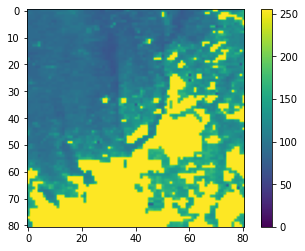

In [23]:
#-- Run the model on a random training example
for img in X_train:
    print('Probability of Fire at Centre Pixel: ',cnn_model.predict_proba(np.expand_dims(img,axis=0))[0][1])
    
    plt.imshow(img.squeeze()*255)
    plt.clim(0,255)
    plt.colorbar()
    plt.show()
    break

True Class:  1.0
Prediction:  0.99592173


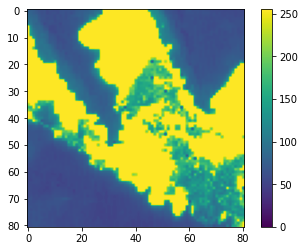

True Class:  1.0
Prediction:  0.99983084


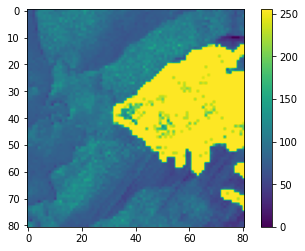

True Class:  1.0
Prediction:  0.9981761


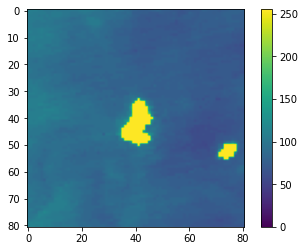

Average time for forward pass:  0.042079591751098634


In [37]:
times = []
for i in range(20):
    img = X_train[i]
    start_time = time.time()
    pred = cnn_model.predict_proba(np.expand_dims(img,axis=0))
    times.append(time.time()-start_time)
    if pred[0][1] >0.99:
        print('True Class: ',y_train_wide[i][1])
        print('Prediction: ',pred[0][1])
        plt.imshow(img.squeeze()*255)
        plt.clim(0,255)
        plt.colorbar()
        plt.show()
print('Average time for forward pass: ',np.mean(times))